

# **Import neccesary Libraries**



In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, Add, GlobalAveragePooling2D, Lambda,	Input, Activation
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np
from tensorflow.keras.optimizers import Adam, Adagrad
from tensorflow.keras import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.optimizers import schedules, SGD
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
import os
from tensorflow.keras.models import load_model
import seaborn as sns

# **ResNet model from scratch using CIFAR10**

# **Loading CIFAR10 dataset**

In [ ]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Print the shapes of the dataset arrays
print("Training data shape (images):", x_train.shape)
print("Training data shape (labels):", y_train.shape)
print("Testing data shape (images):", x_test.shape)
print("Testing data shape (labels):", y_test.shape)

170498071/170498071 [==============================] - 6s 0us/step
Training data shape (images): (50000, 32, 32, 3)
Training data shape (labels): (50000, 1)
Testing data shape (images): (10000, 32, 32, 3)
Testing data shape (labels): (10000, 1)


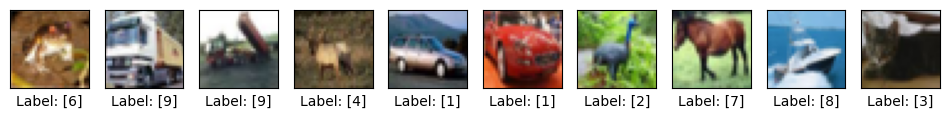

In [ ]:
# Displaying a few images from the training set and their labels
plt.figure(figsize=(12, 12))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i],cmap=plt.cm.binary)
    plt.xlabel(f"Label: {y_train[i]}")
plt.show()


# **Preprocessing on CIFAR10**

## **Normalization**

In [ ]:
print("Before:")
#  check the minimum and maximum values of the data to ensure they are within the expected range [0, 255]
print("Training set - Min:", x_train.min(), "Max:", x_train.max())
print("Test set - Min:", x_test.min(), "Max:", x_test.max())

# Preprocess the data by reshaping and normalizing
train_images_normalized = x_train.reshape((50000, 32, 32, 3)).astype('float32') / 255
test_images_normalized = x_test.reshape((10000, 32, 32, 3)).astype('float32') / 255


print("After:")
#  check the minimum and maximum values of the normalized data to ensure they are within the expected range [0, 1]
print("Normalized training set - Min:", train_images_normalized.min(), "Max:", train_images_normalized.max())
print("Normalized test set - Min:", test_images_normalized.min(), "Max:", test_images_normalized.max())
print("Shape of train_images:", train_images_normalized.shape)
print("Shape of test_images:", test_images_normalized.shape)

Before:
Training set - Min: 0 Max: 255
Test set - Min: 0 Max: 255
After:
Normalized training set - Min: 0.0 Max: 1.0
Normalized test set - Min: 0.0 Max: 1.0
Shape of train_images: (50000, 32, 32, 3)
Shape of test_images: (10000, 32, 32, 3)


## **One-hot Encoding**

In [ ]:

print("Before:")
print("First training label:", y_train[0])  # Print the label of the first training image
print("Eigth test label:", y_test[8]) # Print the label of the seventh test image

# Convert labels to one-hot encoding
train_labels = to_categorical(y_train)
test_labels = to_categorical(y_test)

print("First training label (one-hot):", train_labels[0])  # Print the one-hot encoded label of the first training image
print("Eigth test label (one-hot):", test_labels[8])  # Print the one-hot encoded label of the seventh test image


Before:
First training label: [6]
Eigth test label: [3]
First training label (one-hot): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Eigth test label (one-hot): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


# **Modeling**

## **Building Residual block**

In [ ]:
def create_residual_block(input_features, number_of_filters, increase_filter=False, kernel_size=3):

    shortcut_connection = input_features

    if increase_filter:
        # Use a 1x1 convolution to increase the dimensionality of the shortcut path
        shortcut_connection = Conv2D(number_of_filters, (1, 1), strides=(1, 1), padding='same')(input_features)
        shortcut_connection = BatchNormalization()(shortcut_connection)

    # First convolution layer
    conv_layer1 = Conv2D(number_of_filters, kernel_size, strides=(1, 1), padding='same')(input_features)
    batch_norm_layer1 = BatchNormalization()(conv_layer1)
    relu_activation1 = Activation('relu')(batch_norm_layer1)

    # Second convolution layer
    conv_layer2 = Conv2D(number_of_filters, kernel_size, strides=(1, 1), padding='same')(relu_activation1)
    batch_norm_layer2 = BatchNormalization()(conv_layer2)

    # Combining input features with the output of the convolutional layers
    add_shortcut = Add()([batch_norm_layer2, shortcut_connection])
    relu_activation2 = Activation('relu')(add_shortcut)

    return relu_activation2

## **Buiding the RestNet Structure from scratch**

In [ ]:
def build_resnet_model(input_shape, num_classes):

    # Define the input layer with the given input shape
    model_input = Input(shape=input_shape)

    # Add an initial convolutional layer with 32 filters, a kernel size of 3x3, and 'same' padding to keep output size equal to input
    initial_conv_layer = Conv2D(32, (3, 3), padding='same')(model_input)
    initial_batch_norm = BatchNormalization()(initial_conv_layer)
    initial_relu_activation = Activation('relu')(initial_batch_norm)

    # Build Section A: 3 residual blocks, each with 32 filters.
    # Only the first block will potentially modify the shortcut connection to have the same number of filters as the convolutional layers.
    features_section_a = initial_relu_activation
    for i in range(3):
        # For the first block in this section (when i is 0), increase the filter
        # depth in the shortcut path to match the convolutional layer's depth.
        features_section_a = create_residual_block(features_section_a, 32, increase_filter=(i == 0))

    # Build Section B: Another 3 residual blocks, but with 64 filters.
    # The first block increases the shortcut path's depth to match the new filter size.
    features_section_b = features_section_a
    for i in range(3):
        features_section_b = create_residual_block(features_section_b, 64, increase_filter=(i == 0))

    # Build Section C: The final 3 residual blocks with 128 filters.
    # As before, the first block adjusts the depth of the shortcut connection.
    features_section_c = features_section_b
    for i in range(3):
        features_section_c = create_residual_block(features_section_c, 128, increase_filter=(i == 0))

    # Apply a Global Average Pooling layer to reduce each feature map to a single number per channel.
    # This effectively downsamples the feature maps to a vector.
    global_avg_pooling = GlobalAveragePooling2D()(features_section_c)

    # Flatten the pooled features into a vector to feed into the Dense layer.
    flatten_layer = Flatten()(global_avg_pooling)

    # Add a Dense (fully connected) layer with a softmax activation for classification.
    # The number of neurons equals the number of classes.
    classification_layer = Dense(num_classes, activation='softmax')(flatten_layer)

    # Construct the model by specifying the input and output layers.
    resnet_model = Model(inputs=model_input, outputs=classification_layer)

    return resnet_model


## **Compiling the ResNet Model**

In [ ]:
# Assuming CIFAR-10's input shape and number of classes
input_dimensions = (32, 32, 3)
class_count = 10

# Construct and compile the ResNet model
constructed_resnet_model = build_resnet_model(input_dimensions, class_count)
constructed_resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model's architecture
constructed_resnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 32)           896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 32, 32, 32)           0         ['batch_normalization[0][0

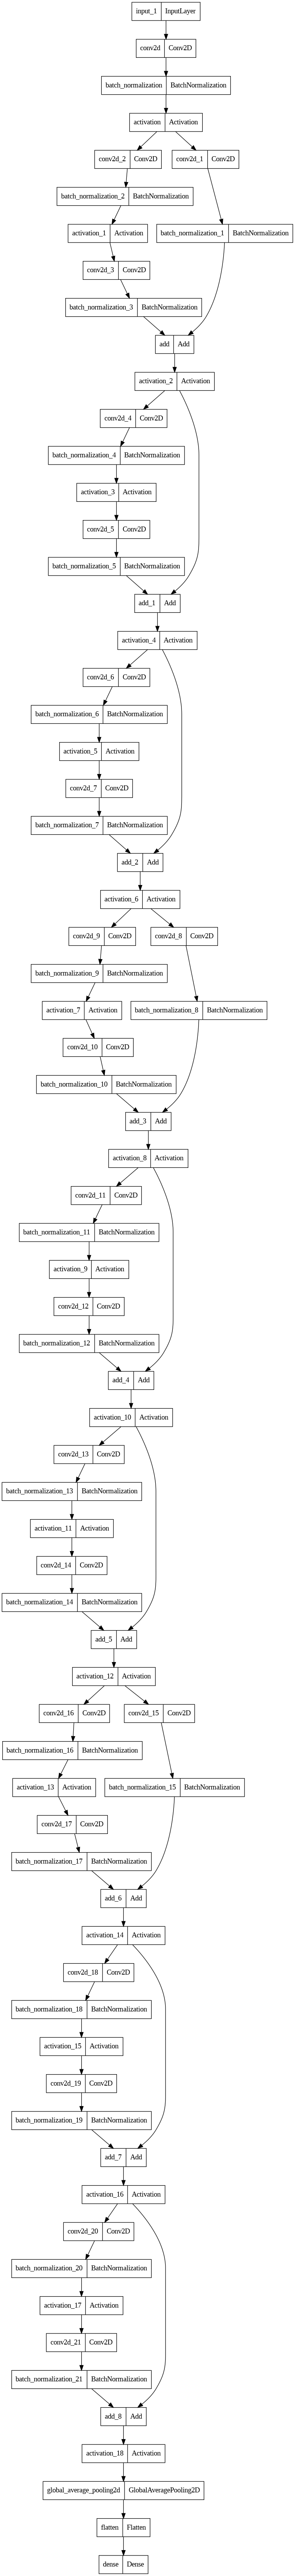

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(constructed_resnet_model)

In [ ]:
plot_model(constructed_resnet_model, to_file='/resnet_model.png', show_shapes=True, show_layer_names=True)

print("Model plot saved as 'resnet_model.png'.")

Model plot saved as 'resnet_model.png'.


## **Training and saving the best model**

In [ ]:
# Create a callback to save the model after each epoch
checkpoint = ModelCheckpoint('resnet_cifar10.h5', save_best_only=True)

# Train the model
history_5 = constructed_resnet_model.fit(train_images_normalized, train_labels, batch_size=32, epochs=10, validation_split=0.2, callbacks=[checkpoint])

# save the final model
constructed_resnet_model.save('resnet_cifar10_final.h5')

Epoch 1/10
1250/1250 [==============================] - ETA: 0s - loss: 1.3845 - accuracy: 0.4978

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1250/1250 [==============================] - 92s 60ms/step - loss: 1.3845 - accuracy: 0.4978 - val_loss: 1.5557 - val_accuracy: 0.4965
Epoch 2/10
1250/1250 [==============================] - 76s 61ms/step - loss: 1.0149 - accuracy: 0.6382 - val_loss: 1.3215 - val_accuracy: 0.5532
Epoch 3/10
1250/1250 [==============================] - 76s 61ms/step - loss: 0.8637 - accuracy: 0.6946 - val_loss: 1.1407 - val_accuracy: 0.6359
Epoch 4/10
1250/1250 [==============================] - 76s 61ms/step - loss: 0.7455 - accuracy: 0.7368 - val_loss: 0.8780 - val_accuracy: 0.6925
Epoch 5/10
1250/1250 [==============================] - 76s 61ms/step - loss: 0.6585 - accuracy: 0.7703 - val_loss: 0.9694 - val_accuracy: 0.6813
Epoch 6/10
1250/1250 [==============================] - 76s 61ms/step - loss: 0.5952 - accuracy: 0.7943 - val_loss: 1.0403 - val_accuracy: 0.6814
Epoch 7/10
1250/1250 [==============================] - 76s 61ms/step - loss: 0.5333 - accuracy: 0.8152 - val_loss: 0.9697 - val_accura

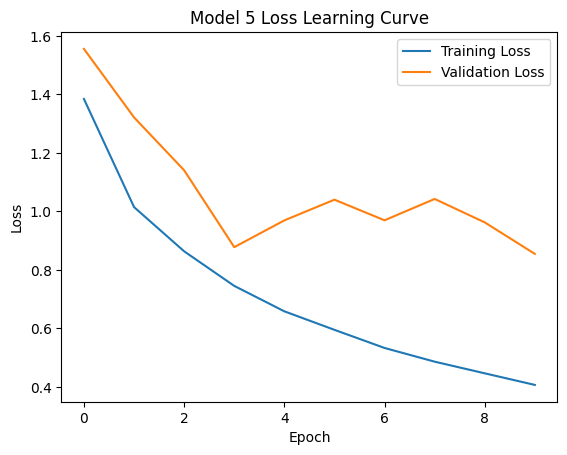

In [ ]:
# Plot Model 5 Loss learning curves
train_loss = history_5.history['loss']
val_loss = history_5.history['val_loss']
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 5 Loss Learning Curve')
plt.legend()
plt.show()

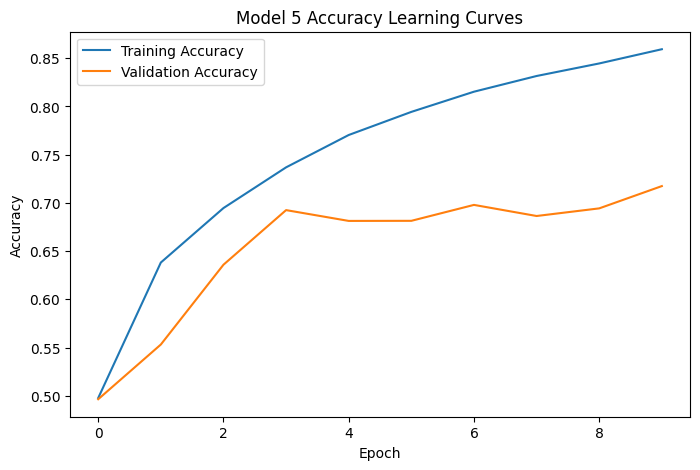

In [ ]:
# Plot learning curves for Model 5 - Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history_5.history['accuracy'], label='Training Accuracy')
plt.plot(history_5.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model 5 Accuracy Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# **Loads a trained ResNet model from a .h5 file.**


In [ ]:

model_file_name = 'resnet_cifar10.h5'
def load_trained_resnet_model(model_file_name):

    if os.path.exists(model_file_name):
        # Load the trained model
        trained_model = load_model(model_file_name)
        print("Trained model loaded successfully.")
        return trained_model
    else:
        # If the file does not exist, raise an exception
        raise FileNotFoundError(f"Trained model file {model_file_name} not found.")

# Use the function to load the model
resnet_model = load_trained_resnet_model(model_file_name)

Trained model loaded successfully.


# **Predict using loaded model.**

In [ ]:

# Load the CIFAR-10 test dataset
(_, _), (x_test, y_test) = cifar10.load_data()

# Normalize the pixel values to the range [0, 1]
x_test_normalized = x_test.astype('float32') / 255.0

313/313 [==============================] - 5s 16ms/step
Accuracy: 0.7936


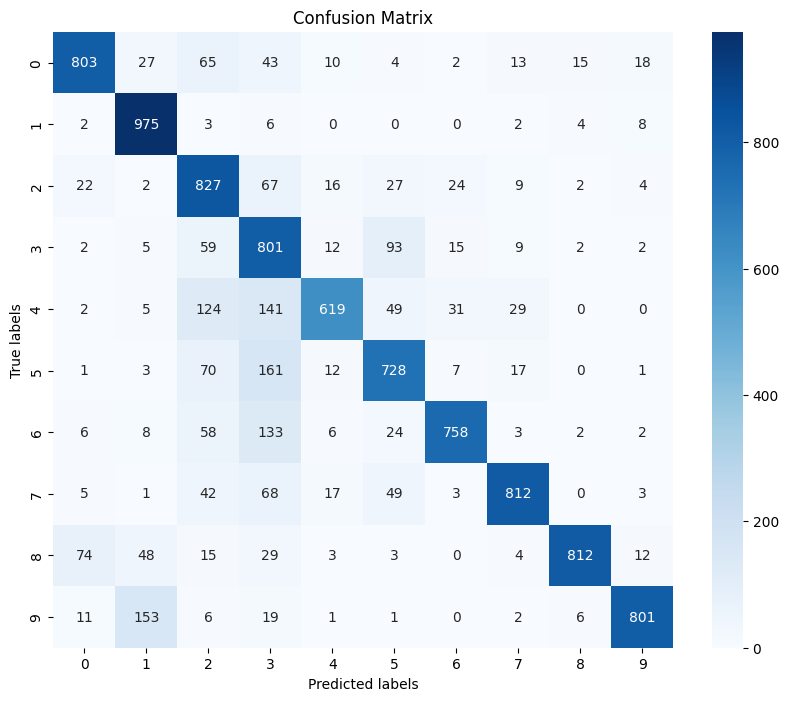

In [ ]:
# Make predictions using the loaded model
predictions = resnet_model.predict(x_test_normalized)

# Convert one-hot encoded predictions back to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, predicted_labels)
print("Accuracy:", accuracy)

# Calculate confusion matrix
cm = confusion_matrix(y_test, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Get the index of the max logit which represents the predicted class
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)
# Generate a classification report
report = classification_report(true_classes, predicted_classes, target_names=[str(i) for i in range(10)])
print(report)

              precision    recall  f1-score   support

           0       0.87      0.80      0.83      1000
           1       0.79      0.97      0.88      1000
           2       0.65      0.83      0.73      1000
           3       0.55      0.80      0.65      1000
           4       0.89      0.62      0.73      1000
           5       0.74      0.73      0.74      1000
           6       0.90      0.76      0.82      1000
           7       0.90      0.81      0.85      1000
           8       0.96      0.81      0.88      1000
           9       0.94      0.80      0.87      1000

    accuracy                           0.79     10000
   macro avg       0.82      0.79      0.80     10000
weighted avg       0.82      0.79      0.80     10000



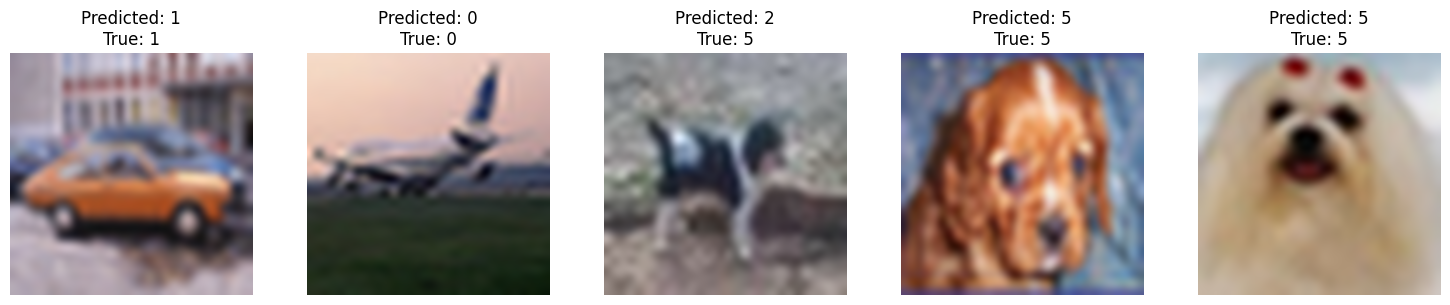

In [ ]:
predicted_classes = np.argmax(predictions, axis=1)
true_classes = y_test_samples.flatten()

# Display the first 5 test images, their predicted, and true labels
plt.figure(figsize=(15, 3))  # Increase figure size for better visibility
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_test[random_indices[i]], interpolation='lanczos')  # Add interpolation
    plt.title(f'Predicted: {predicted_classes[i]}\nTrue: {true_classes[i]}')
    plt.axis('off')  # Disable axis
plt.tight_layout()
plt.show()

